In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import datetime
import math
from scipy.optimize import root
import glob
import os

In [3]:
def c0(x, dt, k):
    return (-2 * x + (dt / k)) / (2 * (1 - x) + (dt / k))
            
def c1(x, dt, k):
    return (2 * x + (dt / k)) / (2 * (1 - x) + (dt / k))

def c2(x, dt, k):
    return (2 * (1 - x) - (dt / k)) / (2 * (1 - x) + (dt / k))

def combine(x, dt, k):
    c_0, c_1, c_2 = c0(x, dt, k), c1(x, dt, k), c2(x, dt, k)
    if math.isclose(c_0 + c_1 + c_2, 1):
        return c_0, c_1, c_2
    else:
        raise warnings.warn(f"Issue with coding: {c_0}, {c_1}, {c_2} = {c_0+ c_1 +c_2}")
    
def prev_date(date, days=1):    
    "function to get prev timestep"
    subtracted_date = pd.to_datetime(date) - datetime.timedelta(days=days)
    subtracted_date = subtracted_date.strftime("%Y-%m-%d")
    return subtracted_date

In [4]:
def obj(params, data, return_df=False):
    x, k = params
    df, dt = data[0], data[1]
    c_0, c_1, c_2 = combine(x, dt, k)
    
    for i, date in enumerate(df.index):
        if i == 0:
            pass
        else:
            day_before = prev_date(date, days=dt)
            if (day_before in df.index):
                i1 = df.loc[day_before,"I"]  # inflow timestep before
                o1 = df.loc[day_before, "O"] # outflow timestep before
                i2 = df.loc[date, "I"]
                o2 = c_0 * i2 + c_1 * i1 + c_2 * o1
                df.loc[date, "Qm"] = o2
                df.loc[date, "RMSE"] = (df.loc[date, "Qm"] - df.loc[date, "O"])**2
            else:
                pass
    RMSE_sum = np.sqrt(df["RMSE"].sum())/ (len(df["RMSE"].dropna()))
    if return_df:
        return df
    return RMSE_sum,RMSE_sum
            
    

In [5]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
files = glob.glob(f"{data_folder}\\Q\\*.parquet")


In [6]:
id_up = '1346000'
id_down = '1358000'
file_up  = glob.glob(f"{data_folder}\\Q\\*{id_up}.parquet")
file_down  = glob.glob(f"{data_folder}\\Q\\*{id_down}.parquet")
df_up = pd.read_parquet(file_up, columns=['Q_mm_d_hydro']).dropna().rename(columns={'Q_mm_d_hydro':'I'})
df_dw = pd.read_parquet(file_down, columns=['Q_mm_d_hydro']).dropna().rename(columns={'Q_mm_d_hydro':'O'})
df_dw.index =  df_dw.index.astype('datetime64[ns]')
df_up.index =  df_up.index.astype('datetime64[ns]')


In [7]:
dt = 1
df = pd.concat([df_up, df_dw],axis=1).dropna()
data = [df, dt]
params = [0.2, 1]

In [8]:
output = root(obj,(0.1, 1), args=(data))
output

 message: The iteration is not making good progress, as measured by the 
            improvement from the last five Jacobian evaluations.
 success: False
  status: 4
     fun: [ 3.394e-03  3.394e-03]
       x: [-2.079e-01  3.615e+00]
    nfev: 35
    fjac: [[-7.071e-01 -7.071e-01]
           [-7.071e-01  7.071e-01]]
       r: [-1.340e-04  6.031e-05 -0.000e+00]
     qtf: [-4.802e-03  4.337e-19]

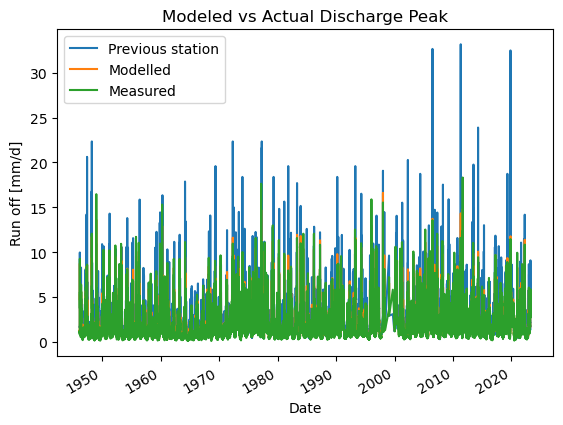

In [10]:
fig, ax = plt.subplots(1)
df_out = obj(output.x, data, return_df=True)[[ "I","Qm", "O"]]
df_out.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Run off [mm/d]')
ax.set_title("Modeled vs Actual Discharge Peak")
ax.legend(["Previous station", "Modelled","Measured"])

<Axes: xlabel='datetime'>

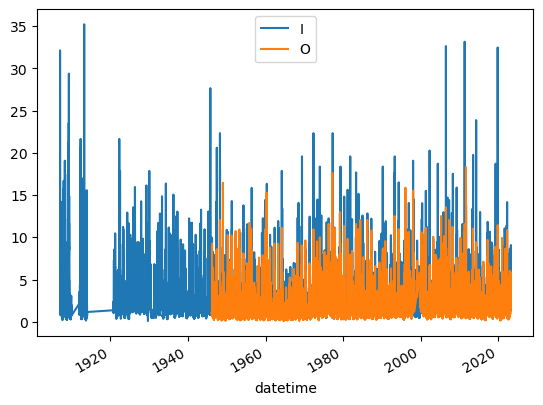

In [155]:
fig, ax = plt.subplots()
df_up.plot(ax=ax)
df_dw.plot(ax=ax)

